In [1]:
import pint
import numpy as np
import matplotlib.pyplot as pl
from fair.constants.general import M_ATMOS
from fair.constants.molwt import AIR as M_AIR
from fair.constants import molwt

class ScmUnitRegistry(pint.UnitRegistry):
    """
    Unit registry class for OpenSCM. Provides some convenience methods to add standard
    unit and contexts.
    """

    def add_standards(self):
        """
        Add standard units.
        Has to be done separately because of pint's weird initializing.
        """
#        self._add_gases(_standard_gases)

        self.define("a = 1 * year = annum = yr")
        self.define("h = hour")
        self.define("d = day")
        self.define("kt = 1000 * t")  # since kt is used for "knot" in the defaults
        self.define('volume_mixing_ratio = [vmr] = vmr')
        self.define('parts_per_million = 1e-6 * volume_mixing_ratio = ppm')
        self.define('parts_per_billion = 1e-9 * volume_mixing_ratio = ppb')
        self.define('parts_per_trillion = 1e-12 * volume_mixing_ratio = ppt')
        self.define('kilometric_ton = kt')

In [2]:
# from openscm.units import _unit_registry as unit
unit = ScmUnitRegistry()
unit.add_standards()
# kiloton = 1*unit.kt
# kiloton.check('[mass]')

In [3]:
M_ATM = M_ATMOS * unit.kg                       # stick this into the main class method
MW_AIR = molwt.AIR * unit.g / unit.mol          # and this

# # TODO: make this a test

In [4]:
class Species:
    pass
    
class GreenhouseGas(Species):
    
#    M_ATMOS = 5.1352e+18 * unit.kg
#    MW_AIR  = 28.97 * unit.g / unit.mol
    
    def __init__(self, radiative_efficiency, reference_concentration, concentration_t0, molecular_weight, name, efficacy=1):
        self.name = name
        self.efficacy = efficacy
        self.radiative_efficiency    = radiative_efficiency
        self.reference_concentration = reference_concentration
        self.concentration_t0        = concentration_t0
        self.molecular_weight        = molecular_weight
        self.kg_to_vmr               = MW_AIR/self.molecular_weight / M_ATM * 1.0 * unit.vmr        
        #if name in library:   # pandas datatable of stats or a csv?
            # load up all the stuff above
            # self.lifetime = library[name].lifetime
            # self.radiative_efficiency = library[name].radiative_efficiency and so on
    
    def set_emissions(self, anthropogenic, natural=0, timestep=1*unit.year):
        self.emissions = anthropogenic
        self.natural_emissions = natural
        self.timestep = timestep
        return Emissions(anthropogenic, natural, timestep)
    
    def set_concentrations(self, concentrations):
        self.concentrations = concentrations
        return Concentrations(concentrations)
        
    def set_lifetime(self, lifetime):
        self.lifetime = lifetime
        
    def calculate_concentrations(self):
        # for GHGs with no temperature feedback or inter-species dependence
        emissions = self.emissions + self.natural_emissions
        nt = len(emissions)   # ensures that either emissions or natural_emissions are array - 
                              # still need to check it is 1D
        concentrations = np.ones(nt+1) * np.nan * unit.vmr

        def _forward(c0, em, ts, lt, vm):   # put this in its own module and import
            c1 = c0*np.exp(-ts/lt) + lt*em*vm * (1.-np.exp(-ts/lt))
            return c1
            
        concentrations[0] = self.concentration_t0
        
        for t in range(nt):
            concentrations[t+1] = _forward(concentrations[t], emissions[t], 
                                         self.timestep, self.lifetime, self.kg_to_vmr)

        self.concentrations = concentrations
        return Concentrations(concentrations)

    def calculate_forcing(self, scale=1):
        # need checks to determine that scale is scalar or array with same length as concentations
        self.effective_radiative_forcing = (self.concentrations - self.reference_concentration) * self.radiative_efficiency * scale
        self.effective_radiative_forcing.ito(unit.watt / unit.m**2)
        return EffectiveRadiativeForcing(self.effective_radiative_forcing)

In [5]:
def etminan(co2, ch4, n2o):
    cbar = 0.5*(co2.reference_concentration + co2.concentrations)
    mbar = 0.5*(ch4.reference_concentration + ch4.concentrations)
    nbar = 0.5*(n2o.reference_concentration + n2o.concentrations)
    
    # units really come into their own here
    co2.effective_radiative_forcing = (
        (-2.4e-7/unit.ppm**2*(co2.concentrations - co2.reference_concentration)**2
         + 7.2e-4/unit.ppm*abs(co2.concentrations-co2.reference_concentration) 
         - 2.1e-4/unit.ppb * nbar + 5.36) 
        * np.log(co2.concentrations/co2.reference_concentration)
    ) * unit.watt / unit.m**2
    
    ch4.effective_radiative_forcing = (
        (-1.3e-6/unit.ppb*mbar - 8.2e-6/unit.ppb*nbar + 0.043) 
        * (np.sqrt(ch4.concentrations/unit.ppb) - np.sqrt(ch4.reference_concentration/unit.ppb))
    ) * unit.watt / unit.m**2
    
    n2o.effective_radiative_forcing = (
        (-8.0e-6/unit.ppm*cbar + 4.2e-6/unit.ppb*nbar - 4.9e-6/unit.ppb*mbar + 0.117)
        * (np.sqrt(n2o.concentrations/unit.ppb) - np.sqrt(n2o.reference_concentration/unit.ppb))
    ) * unit.watt / unit.m**2
    return (
        EffectiveRadiativeForcing(co2.effective_radiative_forcing), 
        EffectiveRadiativeForcing(ch4.effective_radiative_forcing),
        EffectiveRadiativeForcing(n2o.effective_radiative_forcing)
    )
    
    
class CO2(GreenhouseGas):
    def calculate_forcing(self, ch4, n2o):
        etminan(self, ch4, n2o)


class CH4(GreenhouseGas):
    def calculate_forcing(self, co2, n2o):
        etminan(co2, self, n2o)


class N2O(GreenhouseGas):
    def calculate_forcing(self, co2, ch4):
        #self.effective_radiative_forcing = 
        etminan(co2, ch4, self)#[2]

            #self.effective_radiative_forcing = -9999 * unit.watt / unit.m**2
        #return EffectiveRadiativeForcing(self.effective_radiative_forcing)
    
    
class Emissions:
    def __init__(self, anthropogenic, natural, timestep):
        self.emissions=anthropogenic
        self.natural_emissions=natural
        self.timestep=timestep
        
        
class Concentrations:
    def __init__(self, concentrations):
        self.concentrations = concentrations
    
    
class EffectiveRadiativeForcing:
    def __init__(self, effective_radiative_forcing):
        self.effective_radiative_forcing = effective_radiative_forcing
        
        
class Temperature:
    def __init__(self):
        pass

In [6]:
cfc12 = GreenhouseGas(radiative_efficiency=0.32 * unit.watt / unit.m**2 / unit.ppb,
                   reference_concentration=0 * unit.ppt,
                   concentration_t0=0 * unit.ppt,
                   molecular_weight=120.91 * unit.g / unit.mol,
                   name='CFC12')
cfc12.set_emissions(np.ones(1000)*500 * unit.kt / unit.year,
                  natural = 0.00 * unit.kt / unit.year)
cfc12.set_lifetime(100 * unit.years)
cfc12.calculate_concentrations()

# concentrations always returns array of size nt+1

/nfs/see-fs-02_users/mencsm/.local/lib/python3.5/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [7]:
n2o = N2O(
    radiative_efficiency=3.00e-3 * unit.watt / unit.m**2 / unit.ppb,
    reference_concentration=273 * unit.ppb,
    concentration_t0 = 273 * unit.ppb,
    molecular_weight = 44.01 * unit.g / unit.mol,
    name='N2O'
)
n2o.set_concentrations(np.linspace(272,500,1001) * unit.ppb)

In [8]:
ch4 = CH4(
    radiative_efficiency=3.63e-4 * unit.watt / unit.m**2 / unit.ppb,
    reference_concentration=791 * unit.ppb,
    concentration_t0 = 791 * unit.ppb,
    molecular_weight = 16.04 * unit.g / unit.mol,
    name='CH4'  
)
ch4.set_concentrations(np.linspace(791,1800,1001) * unit.ppb)

In [9]:
co2 = CO2(
    radiative_efficiency=1.37e-5 * unit.watt / unit.m**2 / unit.ppb,
    reference_concentration=278 * unit.ppm,
    concentration_t0 = 278 * unit.ppm,
    molecular_weight = 44.01 * unit.g / unit.mol,
    name='CO2'
)
co2.set_concentrations(np.linspace(278,415,1001) * unit.ppm)

In [10]:
class Scenario:
    
    def __init__(self, *args):
        self.species = {}
        self.add_species(*args)
        
    def add_species(self, *args):
        for arg in args:
            self.species[arg.name] = arg
    
    def calculate_forcing(self):
        co2 = self.species['CO2']
        ch4 = self.species['CH4']
        n2o = self.species['N2O']
        for species in self.species:
            if type(self.species[species]) not in [CO2,CH4,N2O]:
                self.species[species].calculate_forcing()
        etminan(co2, ch4, n2o)
        scen.effective_radiative_forcing = (sum([v.effective_radiative_forcing for v in self.species.values()]))
        
    def calculate_temperature(self):
        pass

In [11]:
scen=Scenario(co2, ch4, n2o)
scen.add_species(cfc12)
scen.species

{'CFC12': <__main__.GreenhouseGas at 0x7f7cd9911860>,
 'CH4': <__main__.CH4 at 0x7f7cd8a6f7b8>,
 'CO2': <__main__.CO2 at 0x7f7cd8a7bf60>,
 'N2O': <__main__.N2O at 0x7f7cd99112e8>}

In [12]:
scen.calculate_forcing()
#print(scen.effective_radiative_forcing)

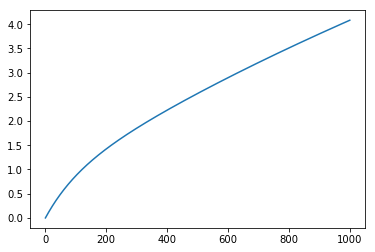

In [13]:
pl.plot(scen.effective_radiative_forcing)

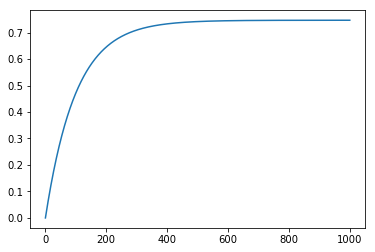

In [14]:
pl.plot(cfc12.effective_radiative_forcing)

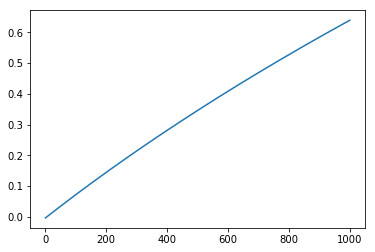

In [15]:
pl.plot(n2o.effective_radiative_forcing)

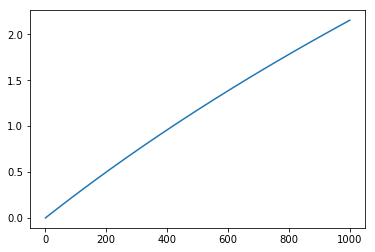

In [16]:
pl.plot(co2.effective_radiative_forcing)

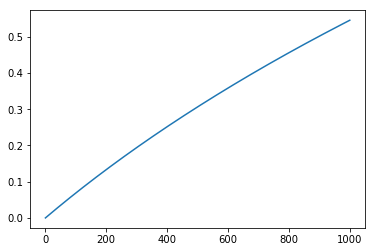

In [17]:
pl.plot(ch4.effective_radiative_forcing)

In [18]:
#pl.plot(n2o.concentrations)

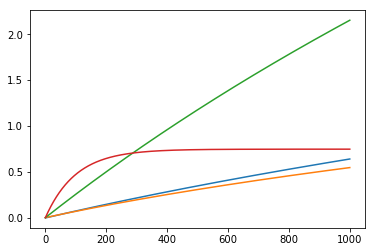

In [19]:
n2o.calculate_forcing(co2, ch4)
ch4.calculate_forcing(co2, n2o)
co2.calculate_forcing(ch4, n2o)
pl.plot(n2o.effective_radiative_forcing)
pl.plot(ch4.effective_radiative_forcing)
pl.plot(co2.effective_radiative_forcing)
pl.plot(cfc12.effective_radiative_forcing)
#cfc12.effective_radiative_forcing

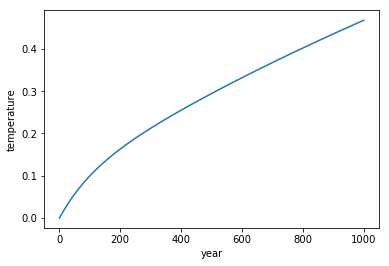

In [22]:
years = np.arange(1001)
# this I think is currently wrong but has not been followed through fully from fair 1.0 - just illustrative
def calculate_temperature(radiative_forcing,
                          efficacy=1,
                          d=np.array([239, 4.1]) * unit.year,
                          q=np.array([0.33,0.41]) * unit.K * unit.m**2 / unit.watt,
                          timestep = 1 * unit.year
                         ):
    # radiative forcing needs to be smartly handled here
    # radiative_forcing = sum_over_all_species_forcing
    nbox = len(q)
    nt = len(radiative_forcing)
    T_j = np.ones((nt, nbox)) * np.nan * unit.K
    T   = np.ones((nt)) * np.nan * unit.K
    
    # Update the thermal response boxes
    T_j[0,:] = (q/d)*radiative_forcing[0] * efficacy * timestep

    # Sum the thermal response boxes to get the total temperature anomaly
    T[0]=np.sum(T_j[0,:],axis=-1)
    
    for t in range(1,nt):
        # Update the thermal response boxes
        T_j[t,:] = T_j[t-1,:]*(1 - np.exp(-timestep/d)) + q * (1-np.exp((-timestep)/d)) * radiative_forcing[t] * efficacy
        # Sum the thermal response boxes to get the total temperature
        T[t]=np.sum(T_j[t,:],axis=-1)
    return T
        
T = calculate_temperature(scen.effective_radiative_forcing)
pl.plot(years, T)
pl.xlabel('year')
pl.ylabel('temperature')

In [ ]:
co2.concentrations